In [1]:
import torch
from torch import nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import optim
from PIL import Image

In [2]:
# loading the pretrained model resnet50

In [3]:
model = models.resnet50(pretrained=True)

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# Preprocess an Input Image

In [6]:
# ResNet-50 expects images of 224x224 pixels, normalized with ImageNet mean & std.

In [7]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
train_dataset = datasets.ImageFolder(root="dogs_vs_cats/train", transform=transform)
test_dataset = datasets.ImageFolder(root="dogs_vs_cats/test", transform=transform)

In [9]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 20000
    Root location: dogs_vs_cats/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [10]:
train_dataset.classes

['cats', 'dogs']

In [11]:
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [12]:
num_classes = len(train_dataset.classes)  # Get number of classes

# Modify last FC layer for custom classification
model.fc = nn.Linear(2048, num_classes)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
model = model.to(device)

In [15]:
# Define Loss & Optimizer
loss_fc = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

In [16]:
# training loop

import time
start_time = time.time()

epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for features , label in train_loader:
        features, label = features.to(device), label.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = loss_fc(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time is {total_time / 60} Minutes!")

Epoch [1/5], Loss: 0.2398
Epoch [2/5], Loss: 0.1535
Epoch [3/5], Loss: 0.1302
Epoch [4/5], Loss: 0.1117
Epoch [5/5], Loss: 0.0999
Total training time is 26.26110059817632 Minutes!


In [17]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for feature, labels in test_loader:
        feature, labels = feature.to(device), labels.to(device)
        outputs = model(feature)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 95.36%


In [18]:
torch.save(model, "resnet50_model.pth")  # Save the whole model

In [20]:
torch.save(model.state_dict(), "resnet50_weights.pth")  # Save only weights

In [21]:
# loading the model for predictions
resnet50 = torch.load("resnet50_model.pth")

C:\Users\kumar\AppData\Local\Temp\ipykernel_23008\3701310358.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet50 = torch.load("resnet50_model.pth")


In [22]:
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
# Load and transform the new image
image_path = "cat1.jpg"
image = Image.open(image_path)  # Open image
image = transform(image).unsqueeze(0)  # Apply transformation and add batch dimension
image = image.to(device)  # Move to GPU if available

In [29]:
import matplotlib.pyplot as plt

In [24]:
# Make Predictions
with torch.no_grad():
    output = resnet50(image)
    predicted_class = torch.argmax(output, dim=1).item()
    
class_name = train_dataset.classes[predicted_class]
print(f"Predicted Class: {class_name}")

Predicted Class: cats


In [27]:
# Interpret Confidence Scores
import torch.nn.functional as F

# Convert logits to probabilities
probabilities = F.softmax(output, dim=1)

# Get top 3 predictions
top2_prob, top2_classes = torch.topk(probabilities, 2)

# Convert results to readable format
for i in range(2):
    print(f"Class: {train_dataset.classes[top2_classes[0][i].item()]}, Probability: {top2_prob[0][i].item():.4f}")

Class: cats, Probability: 0.9997
Class: dogs, Probability: 0.0003


In [32]:
# now we will load the second image
image_path = "dog1.jpg"
original_image = Image.open(image_path) 

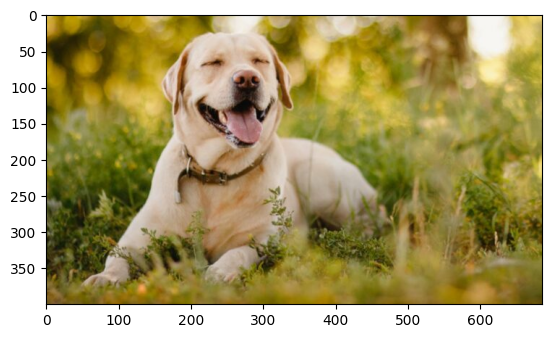

In [33]:
plt.imshow(original_image)

In [34]:
image = transform(original_image).unsqueeze(0)  
image = image.to(device)

In [35]:
# Make Predictions
with torch.no_grad():
    output = resnet50(image)
    predicted_class = torch.argmax(output, dim=1).item()
    
class_name = train_dataset.classes[predicted_class]
print(f"Predicted Class: {class_name}")

Predicted Class: dogs


In [36]:
# Interpret Confidence Scores
import torch.nn.functional as F

# Convert logits to probabilities
probabilities = F.softmax(output, dim=1)

# Get top 3 predictions
top2_prob, top2_classes = torch.topk(probabilities, 2)

# Convert results to readable format
for i in range(2):
    print(f"Class: {train_dataset.classes[top2_classes[0][i].item()]}, Probability: {top2_prob[0][i].item():.4f}")

Class: dogs, Probability: 1.0000
Class: cats, Probability: 0.0000


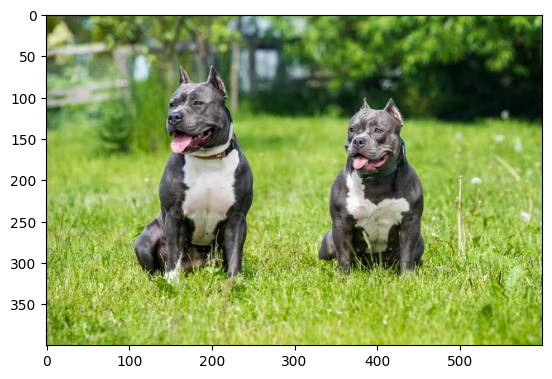

In [38]:
# for another image
image_path = "dog2.jpg"
original_image = Image.open(image_path)
plt.imshow(original_image)

In [39]:
image = transform(original_image).unsqueeze(0)  
image = image.to(device)

In [40]:
# Make Predictions
with torch.no_grad():
    output = resnet50(image)
    predicted_class = torch.argmax(output, dim=1).item()
    
class_name = train_dataset.classes[predicted_class]
print(f"Predicted Class: {class_name}")

Predicted Class: dogs


In [41]:
# Interpret Confidence Scores
import torch.nn.functional as F

# Convert logits to probabilities
probabilities = F.softmax(output, dim=1)

# Get top 3 predictions
top2_prob, top2_classes = torch.topk(probabilities, 2)

# Convert results to readable format
for i in range(2):
    print(f"Class: {train_dataset.classes[top2_classes[0][i].item()]}, Probability: {top2_prob[0][i].item():.4f}")

Class: dogs, Probability: 0.9992
Class: cats, Probability: 0.0008


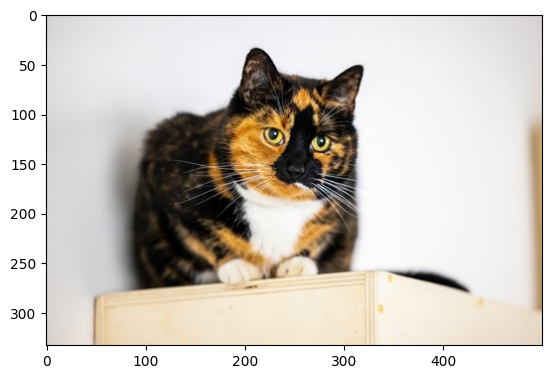

In [42]:
# for another image
image_path = "cat2.jpg"
original_image = Image.open(image_path)
plt.imshow(original_image)

In [43]:
image = transform(original_image).unsqueeze(0)  
image = image.to(device)

In [44]:
# Make Predictions
with torch.no_grad():
    output = resnet50(image)
    predicted_class = torch.argmax(output, dim=1).item()
    
class_name = train_dataset.classes[predicted_class]
print(f"Predicted Class: {class_name}")

Predicted Class: cats


In [45]:
# Interpret Confidence Scores
import torch.nn.functional as F

# Convert logits to probabilities
probabilities = F.softmax(output, dim=1)

# Get top 3 predictions
top2_prob, top2_classes = torch.topk(probabilities, 2)

# Convert results to readable format
for i in range(2):
    print(f"Class: {train_dataset.classes[top2_classes[0][i].item()]}, Probability: {top2_prob[0][i].item():.4f}")

Class: cats, Probability: 0.9979
Class: dogs, Probability: 0.0021


In [47]:
import json

class_labels = train_dataset.classes
class_labels

['cats', 'dogs']

In [48]:
# Save the labels to a JSON file
with open("class_labels.json", "w") as f:
    json.dump(class_labels, f)